In [ ]:
# for colab only
import sys

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/2019-/NN/FANUC/PyCode/')

In [1]:
%matplotlib notebook
import glob
import sys
import os
import warnings

import csv
import torch
import torch.nn as nn
import numpy as np
import random

from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split

from FormatData import FormatData
from Utils import Utils, train, validate, predict, calc_scores, replace_idx_to
from FCNet import FCNet
from FewLayerCNN import FewLayerCNN 
from MDataset import MDataset


warnings.filterwarnings("ignore")

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Check it all and add labels

In [27]:
# Added full labeling

timestr = "2021_06_27_19_40_10"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=45, label=0)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=45, time_end=70, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=70, time_end=88, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=88, time_end=120, label=4)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=120, time_end=125, label=5)
# выделить отдельно в разворот или же норм написать, что это вираж 30 градусов влево?
# turn (разворот) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=125, time_end=155, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=155, time_end=301, label=5)
# turn (вираж) 45 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=301, time_end=311, label=12)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=311, time_end=342, label=5)
# turn (вираж) 15 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=342, time_end=377, label=8)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=377, time_end=680, label=5)
# phone in hands
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=680, time_end=707, label=0)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=707, time_end=722, label=5)
# turn (вираж) 15 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=722, time_end=738, label=8)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=738, time_end=752, label=5)
# turn (вираж) 15 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=752, time_end=760, label=8)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=760, time_end=812, label=5)
# turn (вираж) 30 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=812, time_end=833, label=10)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=833, time_end=968, label=5)
# акробатика, горка
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=968, time_end=1027, label=13)
# акробатика, падение вправо с вертикали
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1027, time_end=1040, label=13)
# акробатика, падение влево под 70 градусов
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1040, time_end=1068, label=13)
# акробатика, горка
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1068, time_end=1085, label=13)
# акробатика, падение вправо с вертикали
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1085, time_end=1099, label=13)
# turn (вираж) 45 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1099, time_end=1177, label=11)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1177, time_end=1182, label=5)
# turn (разворот) 45 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1182, time_end=1190, label=11)
# проход
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1190, time_end=1206, label=14)
# turn (вираж) 45 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1206, time_end=1216, label=12)
# turn (вираж) 45 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1216, time_end=1249, label=11)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1249, time_end=1262, label=5)
# turn (вираж) 15 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1262, time_end=1280, label=8)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1280, time_end=1322, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1322, time_end=1349, label=5)
# # 
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=)
# # 
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=)
# # 
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=)

# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1349, time_end=1399, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1399, time_end=1479, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1479, time_end=1514, label=2)
# add 'aircraft engine is off' label
#labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=0, label=1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1514, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


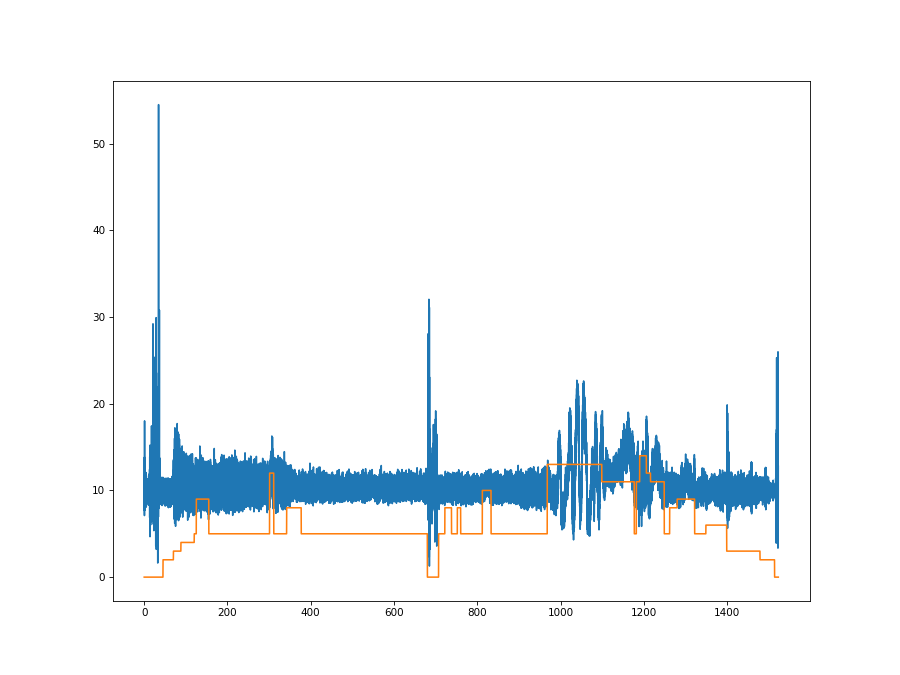

In [28]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels)

In [29]:
# Площадка вылета - Переславль Залесский, посадка Вихрево
# Added full labeling

timestr = "2021_07_03_20_56_10"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=26, label=0)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=26, time_end=208, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=208, time_end=299, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=299, time_end=357, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=357, time_end=378, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=378, time_end=403, label=4)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=403, time_end=432, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=432, time_end=458, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=458, time_end=1588, label=5)

# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1588, time_end=1624, label=0)

# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1624, time_end=1938, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1938, time_end=1948, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1948, time_end=2007, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2007, time_end=2089, label=7)


# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2089, time_end=2126.5, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2126.5, time_end=2211, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2211, time_end=2258, label=2)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2258, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


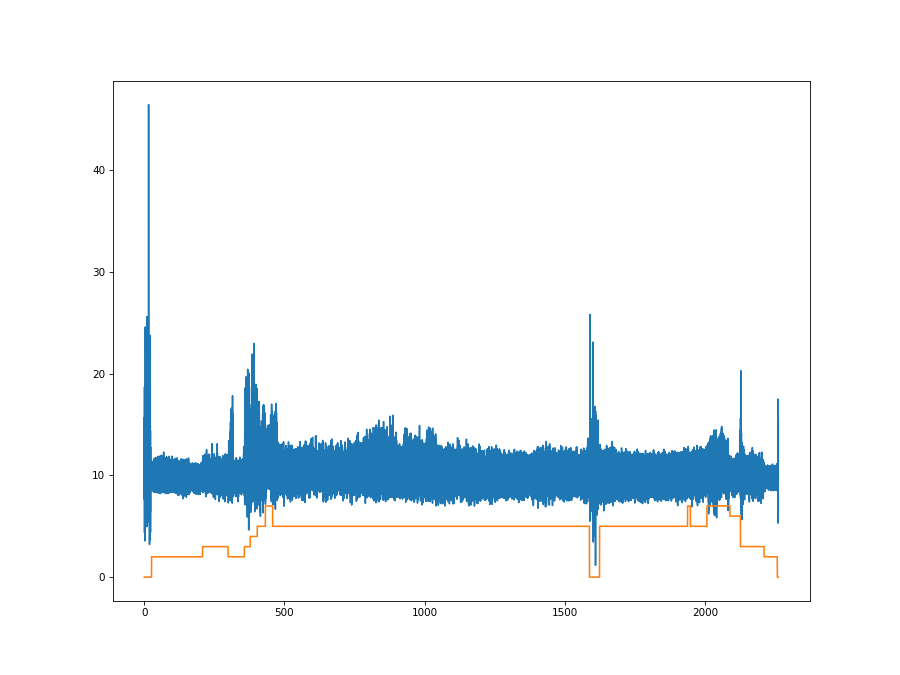

In [30]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels) #, t_start=2120, t_end=2135)

In [31]:
# Added full labeling

timestr = "2021_07_18_18_14_08"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=27, label=0)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=27, time_end=166, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=166, time_end=313, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=313, time_end=408, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=408, time_end=426, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=426, time_end=486, label=4)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=486, time_end=517, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=517, time_end=607, label=5)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=607, time_end=647, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=647, time_end=675, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=675, time_end=693, label=7)
# aircraft is landing
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=693, time_end=721, label=6)
# aircraft is moving on the ground
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=721, time_end=728, label=3)
# aircraft is taking off
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=728, time_end=784, label=4)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=784, time_end=809, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=809, time_end=859, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=859, time_end=882, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=882, time_end=906, label=5)
# turn (вираж) 45 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=906, time_end=933, label=11)
# turn (вираж) 15 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=933, time_end=946, label=8)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=946, time_end=973, label=5)
# turn (вираж) 45 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=973, time_end=987, label=11)
# aircraft is landing
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=987, time_end=1013, label=6)
# aircraft is moving on the ground
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1013, time_end=1022, label=3)
# aircraft is taking off
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1022, time_end=1032, label=4)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1032, time_end=1079, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1079, time_end=1084, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1084, time_end=1101, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1101, time_end=1122, label=5)
# turn (вираж) 15 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1122, time_end=1131, label=8)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1131, time_end=1140, label=5)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1140, time_end=1192, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1192, time_end=1225, label=5)
# turn (вираж) 45 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1225, time_end=1241, label=11)
# aircraft is landing
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1241, time_end=1267, label=6)
# aircraft is moving on the ground
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1267, time_end=1274, label=3)
# aircraft is taking off
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1274, time_end=1318, label=4)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1318, time_end=1348, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1348, time_end=1400, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1400, time_end=1407, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1407, time_end=1410, label=5)
# turn (вираж) 15 deg, right
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1410, time_end=1421, label=8)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1421, time_end=1425, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1425, time_end=1438, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1438, time_end=1463, label=5)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1463, time_end=1494, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1494, time_end=1541, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1541, time_end=1556, label=7)
# aircraft is landing
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1556, time_end=1592, label=6)
# aircraft is moving on the ground
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1592, time_end=1607, label=3)
# aircraft is taking off
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1607, time_end=1638, label=4)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1638, time_end=1659, label=9)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1659, time_end=1668, label=5)
# turn (вираж) 45 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1668, time_end=1681, label=11)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1681, time_end=1722, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1722, time_end=1740, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1740, time_end=1766, label=5)
# turn (вираж) 15 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1766, time_end=1794, label=7)
# cruise
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1794, time_end=1802, label=5)
# turn (вираж) 30 deg, left
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1802, time_end=1829, label=9)
# aircraft is landing
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1829, time_end=1879, label=6)
# aircraft is moving on the ground
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1879, time_end=2051, label=3)
# aircraft engine is on (no motion)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2051, time_end=2072, label=2)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2072, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


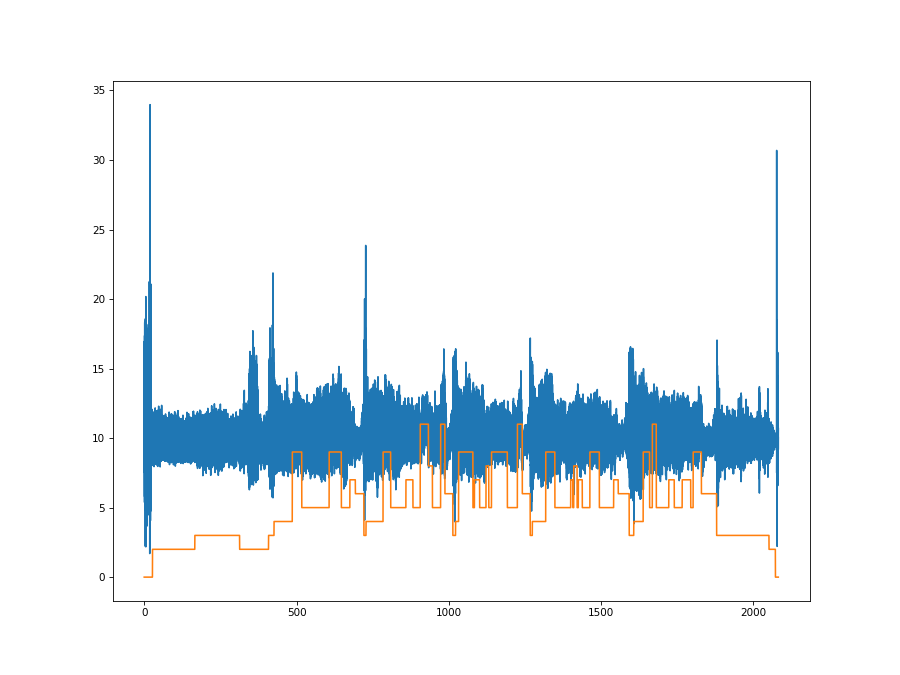

In [32]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels)#, t_start=400, t_end=440)

In [33]:
# Added full labeling

timestr = "2021_10_02_15_57_23"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=18, label=0)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=18, time_end=92, label=1)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=92, time_end=933, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=933, time_end=1083, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1083, time_end=1125, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1125, time_end=1138, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1138, time_end=1170, label=4)


# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1170, time_end=1194, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1194, time_end=1222, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1222, time_end=1266, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1266, time_end=1286, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1286, time_end=1342, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1342, time_end=1366, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1366, time_end=1416, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1416, time_end=1426, label=11)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1426, time_end=1446, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1446, time_end=1490, label=14)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1490, time_end=1527, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1527, time_end=1546, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1546, time_end=1589, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1589, time_end=1609, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1609, time_end=1685, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1685, time_end=1708, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1708, time_end=1754, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1754, time_end=1808, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1808, time_end=1818, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1818, time_end=1856, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1856, time_end=1860, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1860, time_end=1868, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1868, time_end=1890, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1890, time_end=1955, label=14)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1955, time_end=1976, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1976, time_end=1998, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1998, time_end=2037, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2037, time_end=2057, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2057, time_end=2127, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2127, time_end=2153, label=11)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2153, time_end=2203, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2203, time_end=2220, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2220, time_end=2269, label=6)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2269, time_end=2277, label=3)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2277, time_end=2300, label=4)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2300, time_end=2318, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2318, time_end=2338, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2338, time_end=2378, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2378, time_end=2398, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2398, time_end=2467, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2467, time_end=2492, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2492, time_end=2543, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2543, time_end=2560, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2560, time_end=2608, label=6)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2608, time_end=2615, label=3)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2615, time_end=2640, label=4)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2640, time_end=2820, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2820, time_end=2853, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2853, time_end=2924, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2924, time_end=2950, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2950, time_end=2991, label=5)
# горка
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2991, time_end=3027, label=13)
# падение вправо с вертикали
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3027, time_end=3044, label=13)
# падение влево под 70 градусов
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3044, time_end=3065, label=13)
# горка
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3065, time_end=3080, label=13)
# вправо под 70 градусов
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3080, time_end=3108, label=13)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3108, time_end=3130, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3130, time_end=3179, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3179, time_end=3250, label=14)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3250, time_end=3267, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3267, time_end=3286, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3286, time_end=3324, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3324, time_end=3350, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3350, time_end=3409, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3409, time_end=3436, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3436, time_end=3491, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3491, time_end=3507, label=9)

# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3507, time_end=3545, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3545, time_end=3650, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3650, time_end=3720, label=2)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3720, time_end=3730, label=1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3730, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


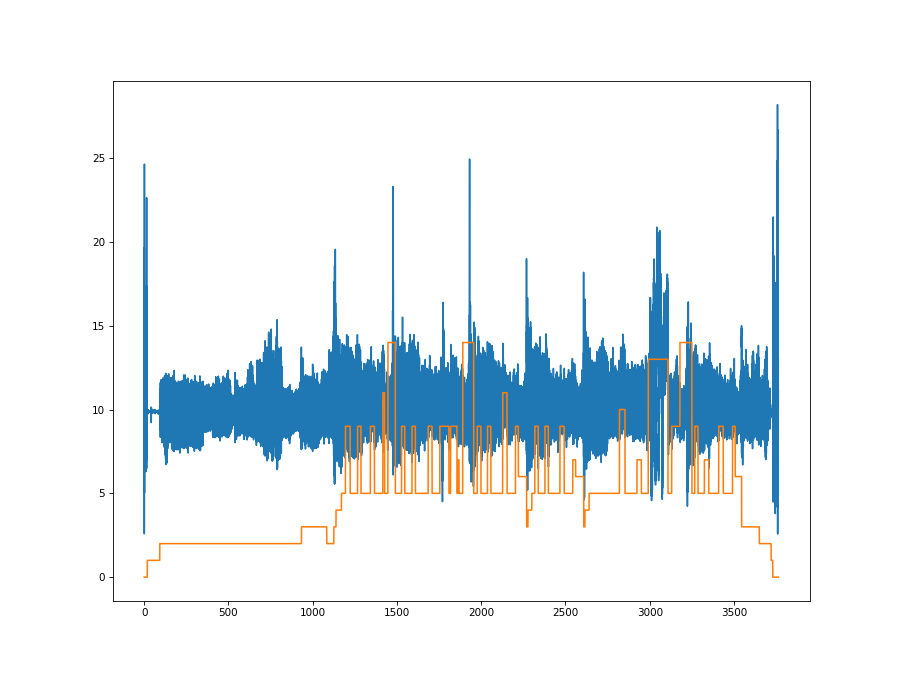

In [34]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels)#, t_start=3530, t_end=3550)

In [35]:
# Пилотаж, неразбираемо

timestr = "2021_08_15_20_14_39"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=5, label=0)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=5, time_end=76, label=1)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=76, time_end=163, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=163, time_end=275, label=3)
# # add 'aircraft engine is on (no motion)' label
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1082, time_end=1124, label=2)
# # add 'aircraft is moving on the ground' label
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1124, time_end=1140, label=3)

# HZ!!!

# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=275, time_end=480, label=4)


# # # add 'phone in hand' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1588, time_end=1620, label=0)

# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2200, time_end=2222.5, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2222.5, time_end=2380, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2380, time_end=2385, label=2)
# # add 'aircraft engine is off' label
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=3720, time_end=3730, label=1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=2385, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


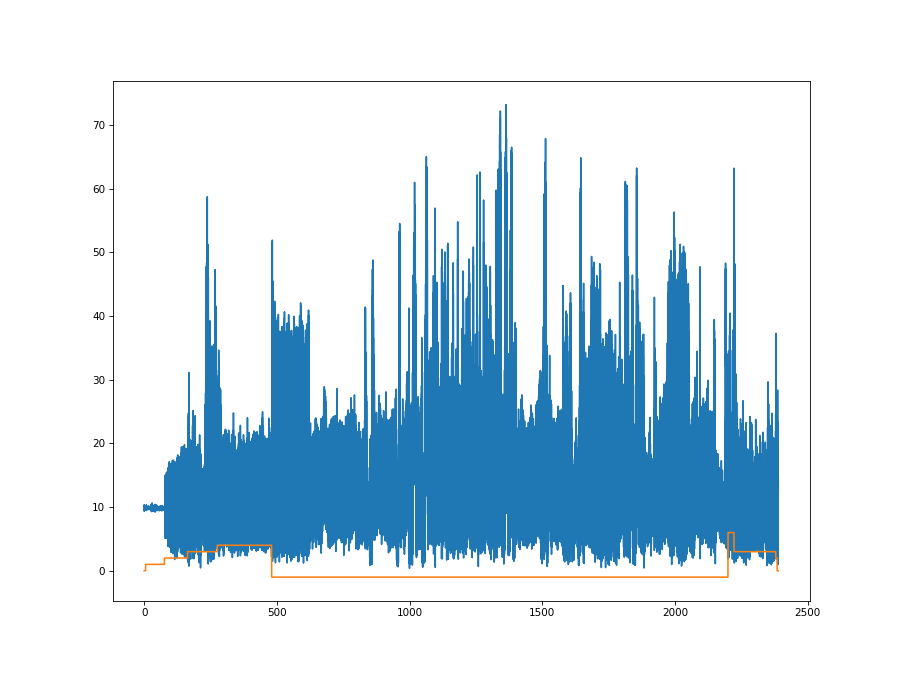

In [36]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels, fsize=(12,9))
#, t_start=2200, t_end=2800)

<IPython.core.display.Javascript object>


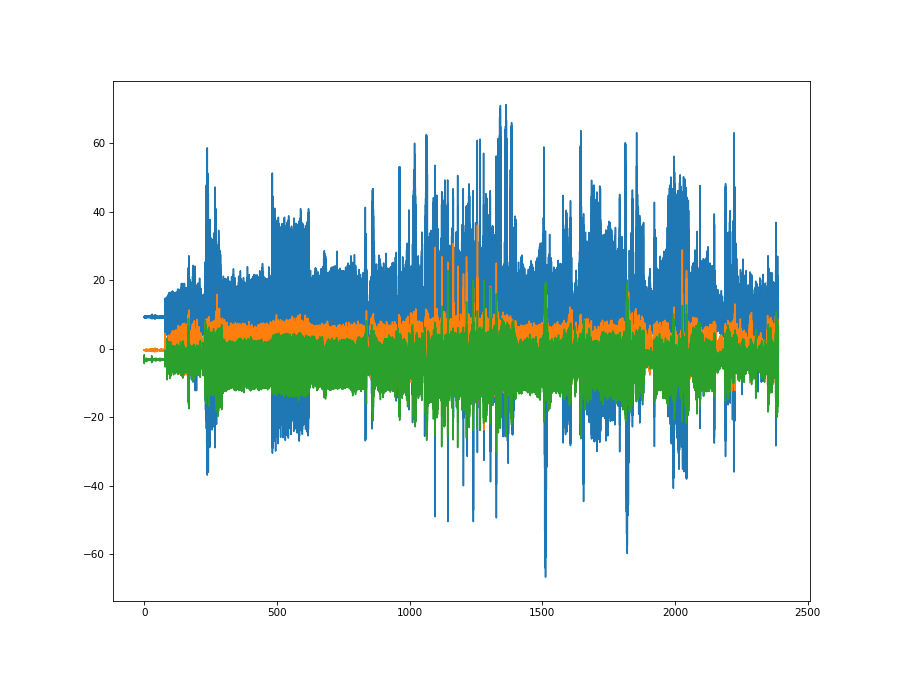

In [37]:
Utils.plot_for_time_interval(xdata=ts, ydata=a[:,0], xdata2=ts, ydata2=a[:,1], 
                          xdata3=ts, ydata3=a[:,2])#, t_start=2200, t_end=2800)

In [38]:
# Added full labeling

timestr = "2021_08_29_15_52_21"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=5, label=0)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=5, time_end=209, label=1)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=209, time_end=214, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=214, time_end=216, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=216, time_end=238, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=238, time_end=332, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=332, time_end=354, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=354, time_end=370, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=370, time_end=390, label=4)


# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=390, time_end=392, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=392, time_end=413, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=413, time_end=416, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=416, time_end=427, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=427, time_end=464, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=464, time_end=480, label=8)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=480, time_end=490, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=490, time_end=558, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=558, time_end=612, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=612, time_end=673, label=11)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=673, time_end=732, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=732, time_end=752, label=10)

# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=752, time_end=779, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=779, time_end=845, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=845, time_end=859, label=2)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=859, time_end=910, label=1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=910, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


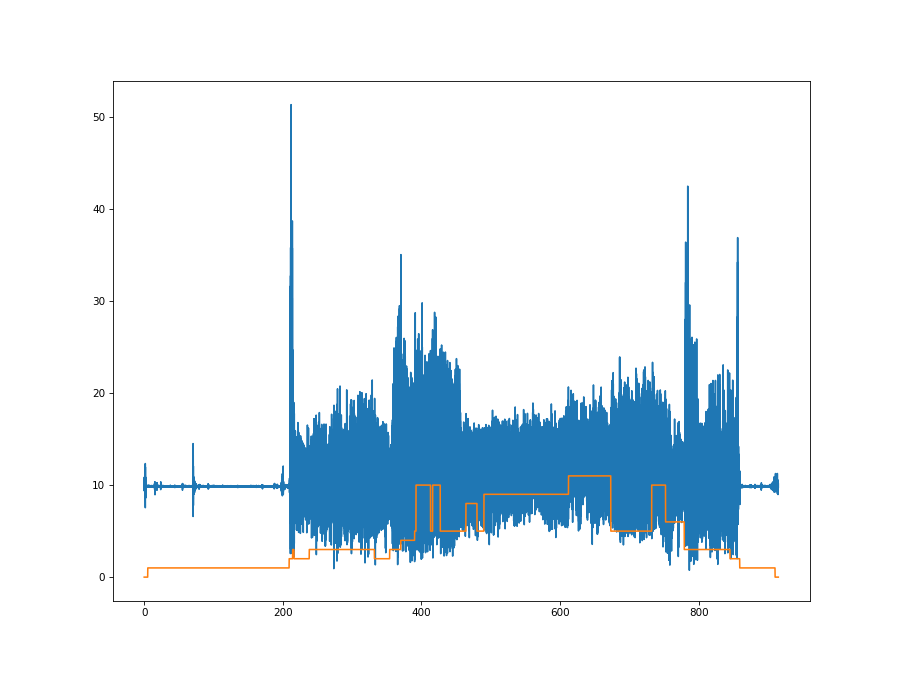

In [39]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels, fsize=(12,9))
#, t_start=2200, t_end=2800)

<IPython.core.display.Javascript object>


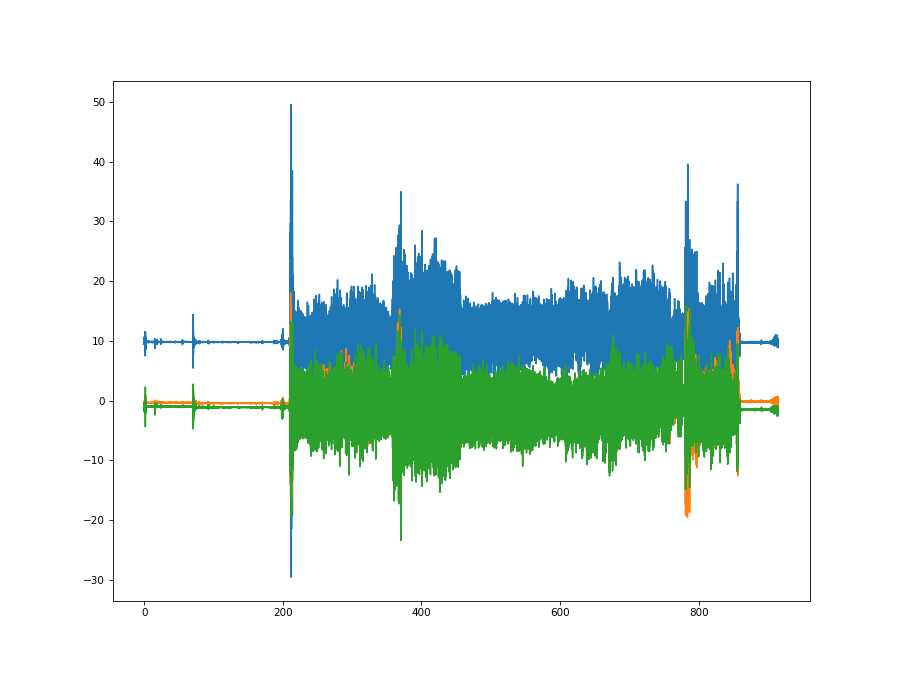

In [40]:
Utils.plot_for_time_interval(xdata=ts, ydata=a[:,0], xdata2=ts, ydata2=a[:,1], 
                          xdata3=ts, ydata3=a[:,2])#, t_start=2200, t_end=2800)

<IPython.core.display.Javascript object>


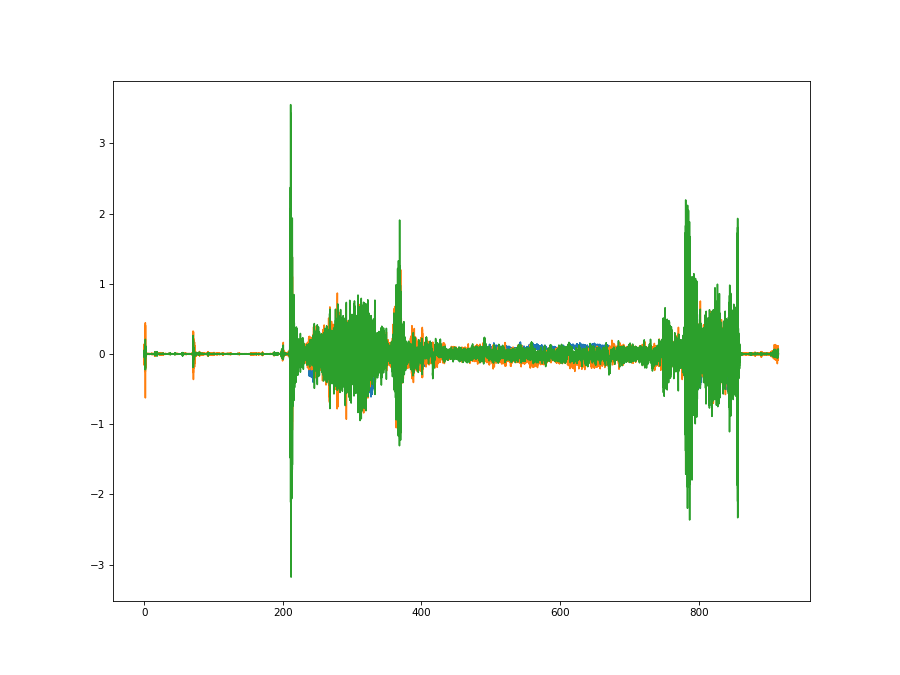

In [41]:
Utils.plot_for_time_interval(xdata=ts, ydata=g[:,0], xdata2=ts, ydata2=g[:,1], 
                          xdata3=ts, ydata3=g[:,2])#, t_start=2200, t_end=2800)

In [42]:
# Added full labeling

timestr = "2021_08_29_16_15_35"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=10, label=0)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=10, time_end=182, label=1)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=182, time_end=208, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=208, time_end=266, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=266, time_end=283, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=283, time_end=297, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=297, time_end=317, label=4)


# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=317, time_end=351, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=351, time_end=363, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=363, time_end=366, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=366, time_end=378, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=378, time_end=395, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=395, time_end=428, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=428, time_end=539, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=539, time_end=600, label=12)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=600, time_end=680, label=5)

# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=680, time_end=723, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=723, time_end=802, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=802, time_end=822, label=2)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=822, time_end=1160, label=1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1160, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


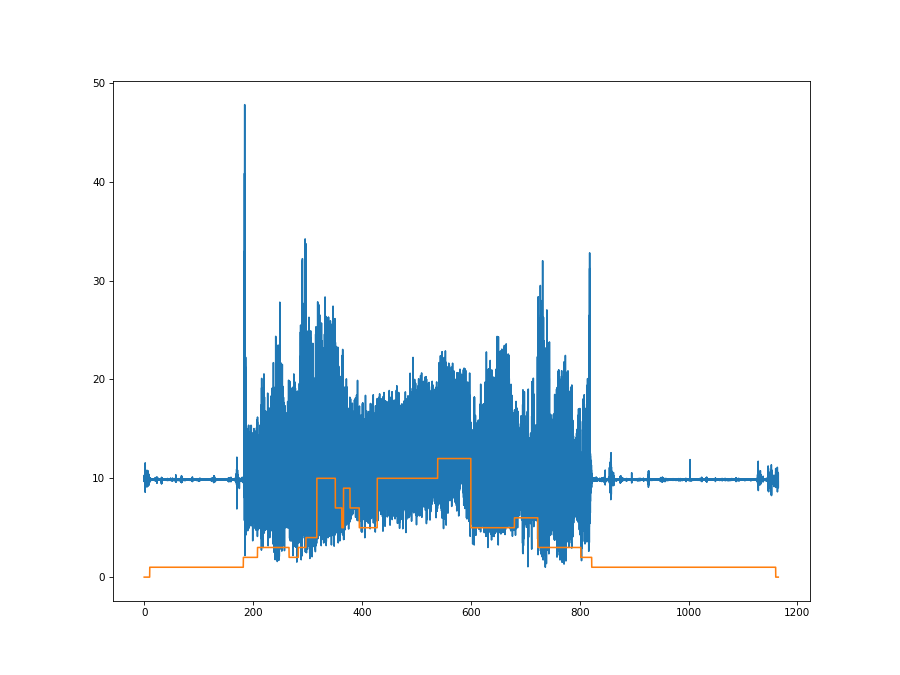

In [43]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels, fsize=(12,9))
#, t_start=2200, t_end=2800)

In [44]:
# Added full labeling

timestr = "2021_08_29_16_41_14"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=5, label=0)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=5, time_end=63, label=1)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=63, time_end=81, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=81, time_end=125, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=125, time_end=157, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=157, time_end=188, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=188, time_end=200, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=200, time_end=218, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=218, time_end=238, label=4)


# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=238, time_end=254, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=254, time_end=298, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=298, time_end=318, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=318, time_end=383, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=383, time_end=393, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=393, time_end=495, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=495, time_end=558, label=12)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=558, time_end=570, label=10)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=570, time_end=590, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=590, time_end=602, label=7)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=602, time_end=657, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=657, time_end=685, label=12)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=685, time_end=702, label=5)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=702, time_end=710, label=9)
# 
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=710, time_end=716, label=5)

# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=716, time_end=740, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=740, time_end=815, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=815, time_end=825, label=2)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=825, time_end=846, label=1)
# add 'phone in hand' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=846, time_end=-1, label=0)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


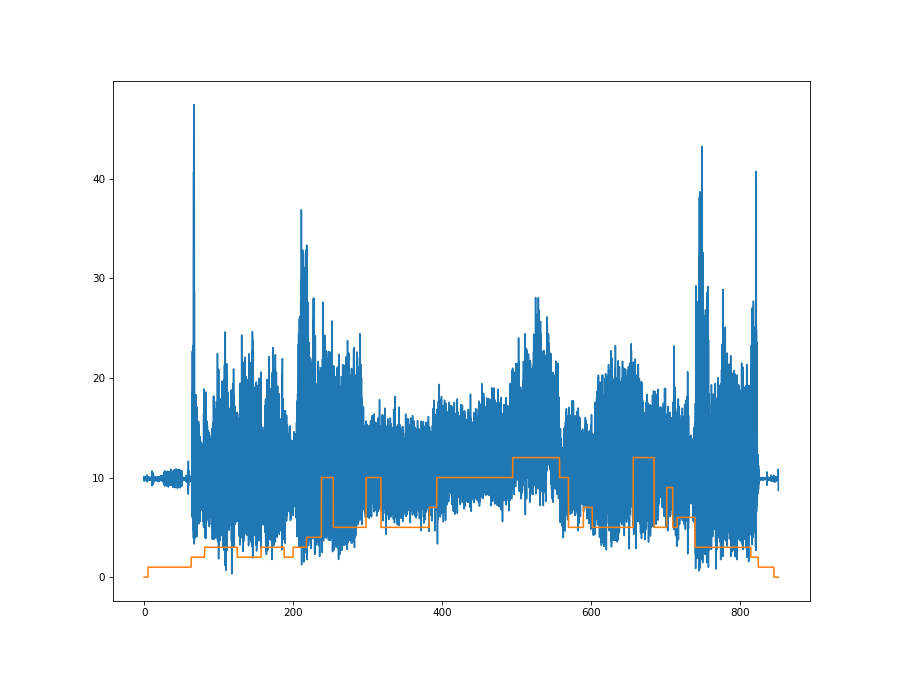

In [45]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels, fsize=(12,9))
#, t_start=2200, t_end=2800)

In [5]:
# Added full labeling

timestr = "2022_05_14_18_13_40"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# # add 'phone in hand' label
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=5, label=0)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=51, label=1)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=51, time_end=66, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=66, time_end=72, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=72, time_end=100, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=100, time_end=235, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=235, time_end=268, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=268, time_end=295, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=295, time_end=338, label=4)


labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=338, time_end=345, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=345, time_end=428, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=428, time_end=457, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=457, time_end=472, label=8)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=472, time_end=506, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=506, time_end=534, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=534, time_end=570, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=570, time_end=582, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=582, time_end=663, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=663, time_end=676, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=676, time_end=739, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=739, time_end=757, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=757, time_end=801, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=801, time_end=823, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=823, time_end=844, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=844, time_end=856, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=856, time_end=930, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=930, time_end=940, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=940, time_end=1005, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1005, time_end=1015, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1015, time_end=1044, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1044, time_end=1049, label=8)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1049, time_end=1069, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1069, time_end=1080, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1080, time_end=1164, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1164, time_end=1184, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1184, time_end=1276, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1276, time_end=1288, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1288, time_end=1297, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1297, time_end=1337, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1337, time_end=1381, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1381, time_end=1406, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1406, time_end=1433, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1433, time_end=1475, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1475, time_end=1509, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1509, time_end=1555, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1555, time_end=1590, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1590, time_end=1617, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1617, time_end=1644, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1644, time_end=1654, label=7)

# # # # # add 'phone in hand' label
# # # # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1588, time_end=1620, label=0)

# 1704 - boom
# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1654, time_end=1704, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1704, time_end=1748, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1748, time_end=1755, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1755, time_end=1877, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1877, time_end=1902, label=2)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1902, time_end=-1, label=1)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
# FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!
Data saved!


<IPython.core.display.Javascript object>


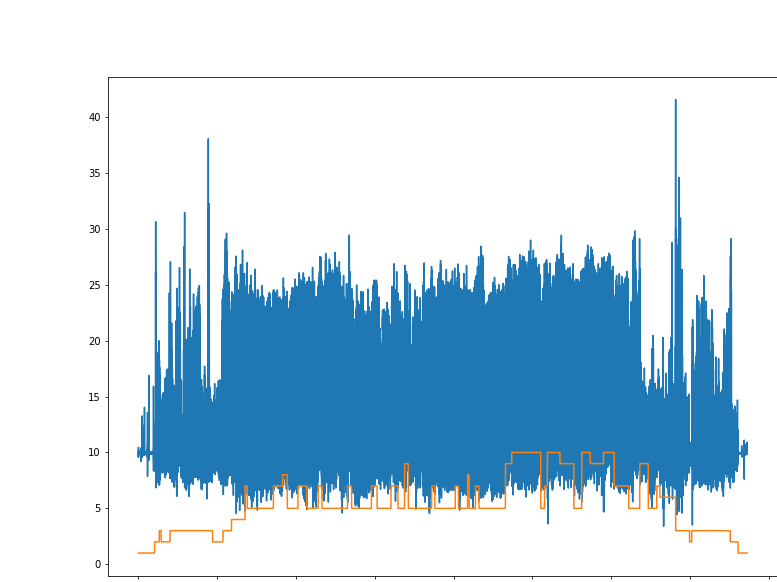

In [4]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels, fsize=(12,9))
#, t_start=2200, t_end=2800)

In [2]:
# Added full labeling

timestr = "2022_05_14_18_13_42"
outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
ts = ts_long.astype(float)

# add undefined labels
labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# # add 'phone in hand' label
# labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=5, label=0)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=50, label=1)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=50, time_end=65, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=65, time_end=71, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=71, time_end=99, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=99, time_end=234, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=234, time_end=267, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=267, time_end=294, label=3)
# add 'aircraft is taking off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=294, time_end=337, label=4)


labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=338 - 1, time_end=345 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=345 - 1, time_end=428 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=428 - 1, time_end=457 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=457 - 1, time_end=472 - 1, label=8)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=472 - 1, time_end=506 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=506 - 1, time_end=534 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=534 - 1, time_end=570 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=570 - 1, time_end=582 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=582 - 1, time_end=663 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=663 - 1, time_end=676 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=676 - 1, time_end=739 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=739 - 1, time_end=757 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=757 - 1, time_end=801 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=801 - 1, time_end=823 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=823 - 1, time_end=844 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=844 - 1, time_end=856 - 1, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=856 - 1, time_end=930 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=930 - 1, time_end=940 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=940 - 1, time_end=1005 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1005 - 1, time_end=1015 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1015 - 1, time_end=1044 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1044 - 1, time_end=1049 - 1, label=8)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1049 - 1, time_end=1069 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1069 - 1, time_end=1080 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1080 - 1, time_end=1164 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1164 - 1, time_end=1184 - 1, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1184 - 1, time_end=1276 - 1, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1276 - 1, time_end=1288 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1288 - 1, time_end=1297 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1297 - 1, time_end=1337 - 1, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1337 - 1, time_end=1381 - 1, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1381 - 1, time_end=1406 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1406 - 1, time_end=1433 - 1, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1433 - 1, time_end=1475 - 1, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1475 - 1, time_end=1509 - 1, label=10)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1509 - 1, time_end=1555 - 1, label=7)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1555 - 1, time_end=1590 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1590 - 1, time_end=1617 - 1, label=9)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1617 - 1, time_end=1644 - 1, label=5)
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1644 - 1, time_end=1654 - 1, label=7)

# # # # # add 'phone in hand' label
# # # # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1588, time_end=1620, label=0)

# 1703 - boom
# add 'aircraft is landing' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1653, time_end=1703, label=6)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1703, time_end=1747, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1747, time_end=1754, label=2)
# add 'aircraft is moving on the ground' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1754, time_end=1876, label=3)
# add 'aircraft engine is on (no motion)' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1876, time_end=1901, label=2)
# add 'aircraft engine is off' label
labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1901, time_end=-1, label=1)

labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# uncomment to write changes in labels
# FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

Data read!


In [4]:
data_with_split = FormatData.make_data_split_for_parts(labeledIMUAsStr, num_parts=10)
for i in range(10):
    FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr + f"_{i}"),
                                 [outIMU[0] + ', label'] + data_with_split[i])

Data saved!
Data saved!
Data saved!
Data saved!
Data saved!
Data saved!
Data saved!
Data saved!
Data saved!
Data saved!


<IPython.core.display.Javascript object>


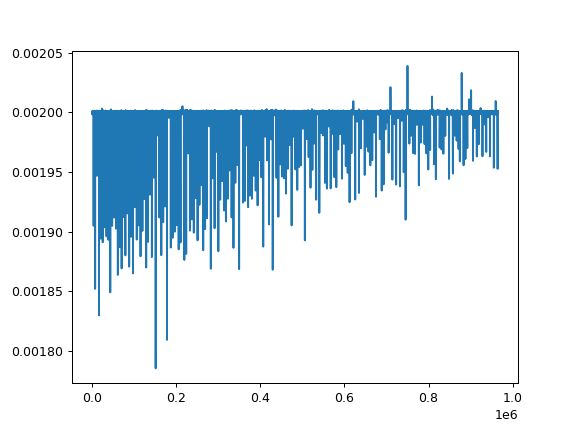

In [13]:
plt.plot((ts_long[1:] - ts_long[0:-1])/1e9)

<IPython.core.display.Javascript object>


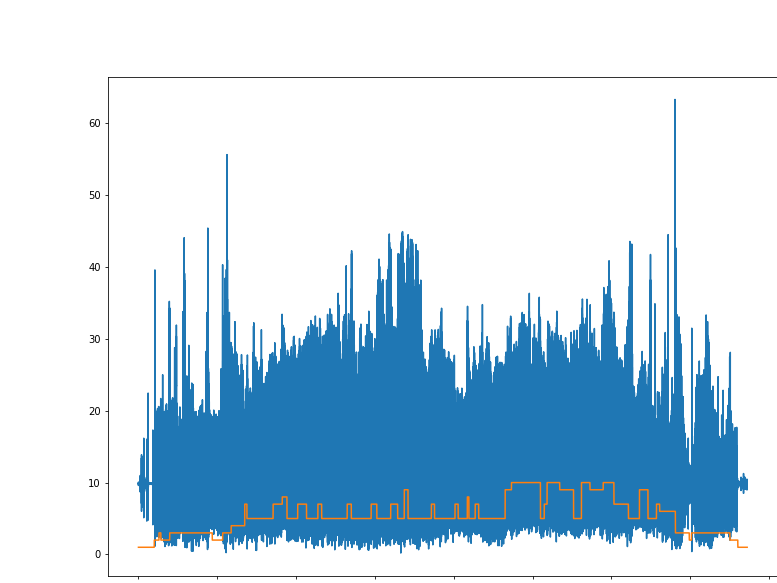

In [8]:
Utils.plot_for_time_interval(ts, Utils.get_magnitudes(a), xdata2=ts, ydata2=labels, fsize=(12,9))
#, t_start=2200, t_end=2800)

In [46]:
# timestr = ""
# outIMU = FormatData.read_data_from_csv(file_name=FormatData.get_IMU_file_name(timestr))
# tmplegendIMU, tmpIMU = FormatData.parse_csv_data(outIMU)
# ts_long, g, a, _ = FormatData.IMU_data_as_numpy_arrays(tmpIMU)
# ts = ts_long.astype(float)

# # add undefined labels
# labels = Utils.make_labeling_for_tick_interval(np.zeros(len(ts), dtype=int), ind_start=0, ind_end=-1, label=-1)
# # # add 'phone in hand' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=0, time_end=5, label=0)
# # # add 'aircraft engine is off' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=5, time_end=, label=1)
# # # add 'aircraft engine is on (no motion)' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=2)
# # # add 'aircraft is moving on the ground' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=3)
# # # add 'aircraft engine is on (no motion)' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=2)
# # # add 'aircraft is moving on the ground' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=3)
# # # add 'aircraft engine is on (no motion)' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=2)
# # # add 'aircraft is moving on the ground' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=3)
# # # add 'aircraft is taking off' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=4)


# # # # # # # add 'phone in hand' label
# # # # # # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=1588, time_end=1620, label=0)

# # # add 'aircraft is landing' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=6)
# # # add 'aircraft is moving on the ground' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=3)
# # # add 'aircraft engine is on (no motion)' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=2)
# # # add 'aircraft engine is off' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=, label=1)
# # # add 'phone in hand' label
# # labels = Utils.make_labeling_for_time_interval(labels, ts, time_start=, time_end=-1, label=0)

# labeledIMUAsStr = FormatData.numpy_arrays_as_IMU_string_data(ts_long, g, a, labels)

# # uncomment to write changes in labels
# # FormatData.write_data_to_csv(FormatData.get_labeled_IMU_file_name(timestr), [outIMU[0] + ', label'] + labeledIMUAsStr)

# Make Split By Maneuver

In [3]:
filepaths = FormatData.get_IMU_file_names_from_dir(fdir=FormatData.get_labeled_files_dir())
fsplitdir = FormatData.get_labeled_files_dir() + "\SplitByManeuver\\"
print(filepaths)

['..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_0.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_4.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_8.csv']


In [4]:
for filep in glob.glob(fsplitdir + "*"):
    os.remove(filep)

In [10]:
# Clear folder
for filep in glob.glob(fsplitdir + "*"):
    os.remove(filep)

min_maneuver_len = 10000000
max_maneuver_len = 0
maneuvers_quantity_by_types = np.zeros(15, dtype=int)
flabels = []
j = 0

for filep in filepaths:
    # read file
    out = FormatData.read_data_from_csv(file_name=filep, b_print_end_msg=False)
    _, out_parsed = FormatData.parse_csv_data(out, has_legend=True) 
    
    # get all parts with labels >= 0
    strlen = len(out_parsed[0]) - 1
    thislabel=out_parsed[0][strlen]
    max_ind = len(out_parsed)
    
    i = 0 # for flight file length
    #k = 0 # for maneuver length
    while i < max_ind:
        thislabel=out_parsed[i][strlen]
        # print(thislabel)
        # check whether were labeled or not
        if thislabel != "-1":
            mdata = []
            while i < max_ind and out_parsed[i][strlen] == thislabel:# and k < 5000:
                mdata.append(out_parsed[i])
                i = i + 1
                #k = k + 1
            # calc maneuvers quantity
            maneuvers_quantity_by_types[int(thislabel)] = maneuvers_quantity_by_types[int(thislabel)] + 1
            # check for length of smallest and longest data parts
            if min_maneuver_len > len(mdata):
                min_maneuver_len = len(mdata)
            if max_maneuver_len < len(mdata):
                max_maneuver_len = len(mdata)
                
            FormatData.write_data_to_csv(fsplitdir + f"M_{j}_label_{thislabel}" + ".csv", 
                                      FormatData.arrays_as_string_data(mdata, b_remove_last=True, labels=[]), 
                                      b_print_end_msg=False)
            k = 0
            j = j + 1
            flabels.append(int(thislabel))
            # print(thislabel)
        else:
            i = i + 1

FormatData.write_data_to_csv(file_name=fsplitdir + "L.csv", data_list=flabels, b_print_end_msg=True)

print(min_maneuver_len)
print(max_maneuver_len)
print(maneuvers_quantity_by_types)

Data saved!
250
6751
[ 0  6 15 15  3 48  3 39  6 15 12  0  0  0  0]


In [11]:
np.sum(maneuvers_quantity_by_types)

162